In [1]:
import ipympl
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os

In [2]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
PATH = glob.glob(os.path.expanduser('.'))[0]
writer = SummaryWriter('{}{}'.format(PATH, datetime.now().strftime('%b%d_%H-%M-%S')))

Furthest Position: -0.16406828837717388


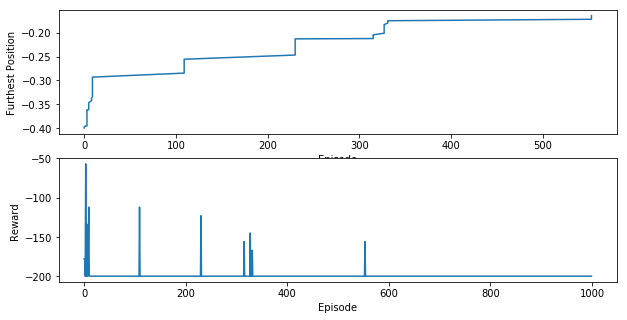

successful episodes: 0


In [3]:
max_position = -.4
positions = np.ndarray([0,2])
rewards = []
successful = []
for episode in range(1000):
    running_reward = 0
    env.reset()
    done = False
    for i in range(200):
        state, reward, done, _ = env.step(np.random.randint(0,3))
        # Give a reward for reaching a new maximum position
        if state[0] > max_position:
            max_position = state[0]
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward
        if done: 
            if state[0] >= 0.5:
                successful.append(episode)
            rewards.append(running_reward)
            break

print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('successful episodes: {}'.format(np.count_nonzero(successful)))

In [4]:
# I tried different weight initializations but found they did not perform well.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

In [5]:
# Parameters
steps = 200
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 1000
max_position = -0.4
learning_rate = 0.001
successes = 0
position = []

policy = Policy()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()
    
    for s in range(steps):
#         if episode % 100 == 0 and episode > 0:
#             env.render()
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
      
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        state_1, reward, done, _ = env.step(action)
    
        reward = state_1[0] + 0.5
        if state_1[0] >= 0.5:
            reward += 1
        
        Q1 = policy(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        
        Q_target = Q.clone()
        Q_target = Variable(Q_target)
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)    
        
        loss = loss_fn(Q, Q_target)
         
        policy.zero_grad()
        loss.backward()
        optimizer.step()
        
        episode_loss += loss.item()
        episode_reward += reward
        
        if done:
            print(state_1[0])
            if state_1[0] >= 0.5:
                epsilon *= .95s
                # Adjust learning rate
                scheduler.step()
                #optimizer.param_groups[0]['lr'] = max(optimizer.param_groups[0]['lr'], 1.0e-4)
                successes += 1
            break
        else:
            state = state_1

print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

100%|██████████| 1000/1000 [02:43<00:00,  9.25it/s]

successful episodes: 648 - 64.8000%


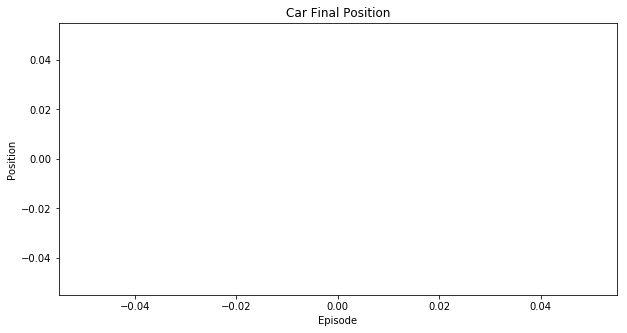

In [6]:
plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position - Modified.png')
plt.show()